<a href="https://colab.research.google.com/github/CSpanias/ml_training/blob/master/DecisionTreeRegressor_tips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Decision Tree Regressor Algorithm**

*This notebook was developed for Decision Tree practice and the resulting code is a blend of various different resources.*

Based mostly on:
* [Machine Learning for Absolute Beginners](https://scatterplotpress.teachable.com/courses)



1. [Data PreProcessing](#PrePro)
2. [Cross-Validation](#KFold)
3. [Decision Tree Visualization (GraphViz)](#GraphViz)
4. [Pruning the Decision Tree](#Pre-Pruning)
5. [Conclusions](#Conclusions)


In [34]:
import numpy as np # convert DataFrame to arrays, calculate means
import pandas as pd # read dataset, one-hot encoding
import seaborn as sns # visualization

from sklearn.tree import DecisionTreeRegressor # algorithm required
from sklearn.model_selection import GridSearchCV # hyperparameter optimization
from sklearn.model_selection import KFold, cross_validate # perform a KFold Cross-Validation
from sklearn.metrics import mean_absolute_error, accuracy_score # evaluation metrics

In [2]:
# load data
df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv")

In [3]:
# print the first 5 rows of data
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
# print info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


<a name="PrePro"> </a>
# **Data PreProcessing**

* Missing values
* Duplicate rows
* EDA
* Discretization

In [5]:
# check for missing values
df.isna().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [6]:
# check for duplicates
print(df.duplicated().sum())

1


In [7]:
# remove duplicate rows
df.drop_duplicates(inplace=True)

**Discretization**: convert categorical into numerical variables.

In [8]:
# convert non-numerical data to boolean using one-hot encoding
df = pd.get_dummies(df, columns=['time', 'day', 'sex', 'smoker'])

Check for **multi-collinearity**:

In [9]:
df.corr()

,total_bill,tip,size,time_Dinner,time_Lunch,day_Fri,day_Sat,day_Sun,day_Thur,sex_Female,sex_Male,smoker_No,smoker_Yes
total_bill,1.000000,0.674998,0.597589,0.179232,-0.179232,-0.087201,0.052703,0.121096,-0.133758,-0.141350,0.141350,-0.090136,0.090136
tip,0.674998,1.000000,0.488400,0.117596,-0.117596,-0.056398,-0.005016,0.123360,-0.091433,-0.085274,0.085274,-0.009763,0.009763
size,0.597589,0.488400,1.000000,0.100045,-0.100045,-0.143033,-0.043040,0.191713,-0.068834,-0.083248,0.083248,0.130564,-0.130564
time_Dinner,0.179232,0.117596,0.100045,1.000000,-1.000000,-0.060416,0.460764,0.416226,-0.917076,-0.198129,0.198129,-0.063911,0.063911
time_Lunch,-0.179232,-0.117596,-0.100045,-1.000000,1.000000,0.060416,-0.460764,-0.416226,0.917076,0.198129,-0.198129,0.063911,-0.063911
day_Fri,-0.087201,-0.056398,-0.143033,-0.060416,0.060416,1.000000,-0.217495,-0.196472,-0.168609,0.072950,-0.072950,-0.246709,0.246709
day_Sat,0.052703,-0.005016,-0.043040,0.460764,-0.460764,-0.217495,1.000000,-0.503786,-0.432341,-0.050085,0.050085,-0.160366,0.160366
day_Sun,0.121096,0.123360,0.191713,0.416226,-0.416226,-0.196472,-0.503786,1.000000,-0.390551,-0.165155,0.165155,0.178861,-0.178861
day_Thur,-0.133758,-0.091433,-0.068834,-0.917076,0.917076,-0.168609,-0.432341,-0.390551,1.000000,0.186796,-0.186796,0.138821,-0.138821
sex_Female,-0.141350,-0.085274,-0.083248,-0.198129,0.198129,0.072950,-0.050085,-0.165155,0.186796,1.000000,-1.000000,0.009930,-0.009930


Visualize data for multi-collinearity:

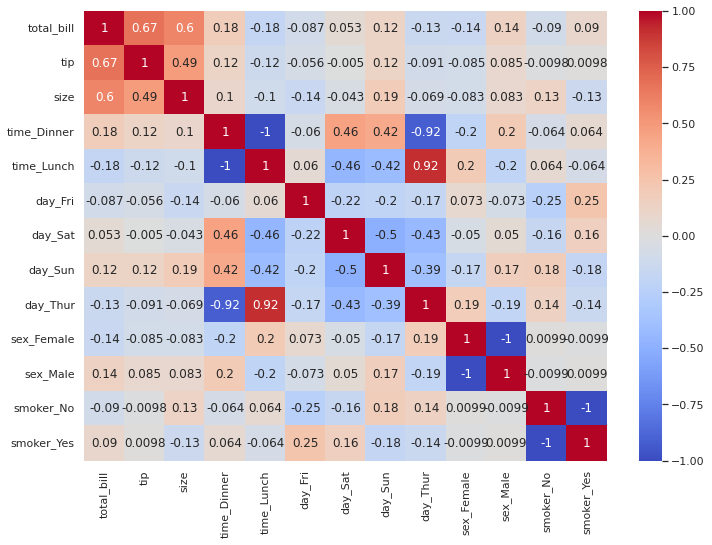

In [10]:
# set figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
# generate a heatmap
sns.heatmap(df.corr(), annot=True,cmap='coolwarm')

The relationshop between the tip (target) and smoker variable for both No and Yes is **extremely small** (absolute value: 0.009763). 

Therefore this variable can be removed:

In [13]:
# delete smoker variable
del df['smoker_No']
del df['smoker_Yes']

<a name='KFold'> </a>
 # **KFold Cross Validation with different criterion** 
(squared_error, friedman_mse, absolute_error, poisson)

1. Assign Xs (features) & y (target) 
2. Convert them from pandas DataFrame (matrix) and pandas Series (single column) to ***numpy 2- and 1-Dimensional numpy arrays***, respectively.

  Pandas DataFrames & Series are easier to read by a human, but numpy's arrays are ***easier to handled by the computer***.  

In [27]:
# from df drop the specified variable, axis=1: drop the whole column
X = df.drop(columns='tip', axis=1)
# convert pandas dataframe to a 2-Dimensional numpy array
X = X.values
# confirm that X's shape is 2D
print(X.shape)

# assing target
y = df['tip']
# convert pandas series to a 1-Dimensional numpy array
y = y.values
# confirm that y's shape is 1D
print(y.shape)

(243, 10)
(243,)


In [76]:
kf = KFold(n_splits=10, shuffle=True)
model = DecisionTreeRegressor()
cv_scores = cross_validate(model, X, y, scoring='neg_mean_squared_error',
               cv=kf, return_train_score=True, verbose=3)

[CV] END ................., score=(train=-0.002, test=-3.049) total time=   0.0s
[CV] END ................., score=(train=-0.002, test=-1.006) total time=   0.0s
[CV] END ................., score=(train=-0.000, test=-1.654) total time=   0.0s
[CV] END ................., score=(train=-0.000, test=-2.612) total time=   0.0s
[CV] END ................., score=(train=-0.002, test=-1.597) total time=   0.0s
[CV] END ................., score=(train=-0.002, test=-2.036) total time=   0.0s
[CV] END ................., score=(train=-0.002, test=-1.711) total time=   0.0s
[CV] END ................., score=(train=-0.002, test=-2.017) total time=   0.0s
[CV] END ................., score=(train=-0.002, test=-1.277) total time=   0.0s
[CV] END ................., score=(train=-0.002, test=-2.009) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


<a name="GS"> </a>
# **Hyperparameter Optimization**

In [32]:
# define the number of splits (train/test sets) and shuffle rows
kf = KFold(n_splits=10, shuffle=True)

# select algorithm with the specified criterion
model = DecisionTreeRegressor()

# set the parameters of the gridsearch
param_grid = {
              'splitter': ['best', 'random'],
              'max_features': ['auto', 'sqrt', 'log2'],
              }

# select algorithm
model = DecisionTreeRegressor()

# set the gridsearch
gs = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=kf, verbose=3)

# train the gs
gs.fit(X, y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10] END max_features=auto, splitter=best;, score=-1.218 total time=   0.0s
[CV 2/10] END max_features=auto, splitter=best;, score=-0.867 total time=   0.0s
[CV 3/10] END max_features=auto, splitter=best;, score=-1.358 total time=   0.0s
[CV 4/10] END max_features=auto, splitter=best;, score=-0.901 total time=   0.0s
[CV 5/10] END max_features=auto, splitter=best;, score=-0.978 total time=   0.0s
[CV 6/10] END max_features=auto, splitter=best;, score=-0.969 total time=   0.0s
[CV 7/10] END max_features=auto, splitter=best;, score=-0.978 total time=   0.0s
[CV 8/10] END max_features=auto, splitter=best;, score=-1.067 total time=   0.0s
[CV 9/10] END max_features=auto, splitter=best;, score=-0.949 total time=   0.0s
[CV 10/10] END max_features=auto, splitter=best;, score=-1.140 total time=   0.0s
[CV 1/10] END max_features=auto, splitter=random;, score=-1.050 total time=   0.0s
[CV 2/10] END max_features=auto, splitter=ran

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=3)

Evalute GS results:

In [33]:
# suggest parameters by GS
print(gs.best_params_)

# best score by best params
print(gs.best_score_)

{'max_features': 'log2', 'splitter': 'random'}
-1.0118683333333334


In [83]:
# select algorith and set entropy as the criterion
model = DecisionTreeRegressor(max_features='log2', splitter='random')
# train and assess model
cv_scores = cross_validate(model, X, y, scoring='neg_mean_squared_error',
               cv=kf, return_train_score=True)

print("Mean CV training MSE:")
print(np.mean(cv_scores['train_score']))

print("\nMean CV testing MSE:")
print(np.mean(cv_scores['test_score']))

Mean CV training accuracy:
-0.0018275313141468727

Mean CV testing accuracy:
-2.142033816666667


<a name='GraphViz'> </a>
# **Decision Tree Visualization** (GraphViz)

Decision Trees benefits:
1. **Interpretability**: clarity of information representation, useful for explaining the prediction to a non-technical audience.
2. **Transparency**: can greatly help in the *decision making process*. 

*If you're going to run this on your computer, make sure to install graphviz first. You can do this by opening your command prompt and typing "**pip install graphviz**".*

Sample Visualization for easier interpretation of the process:

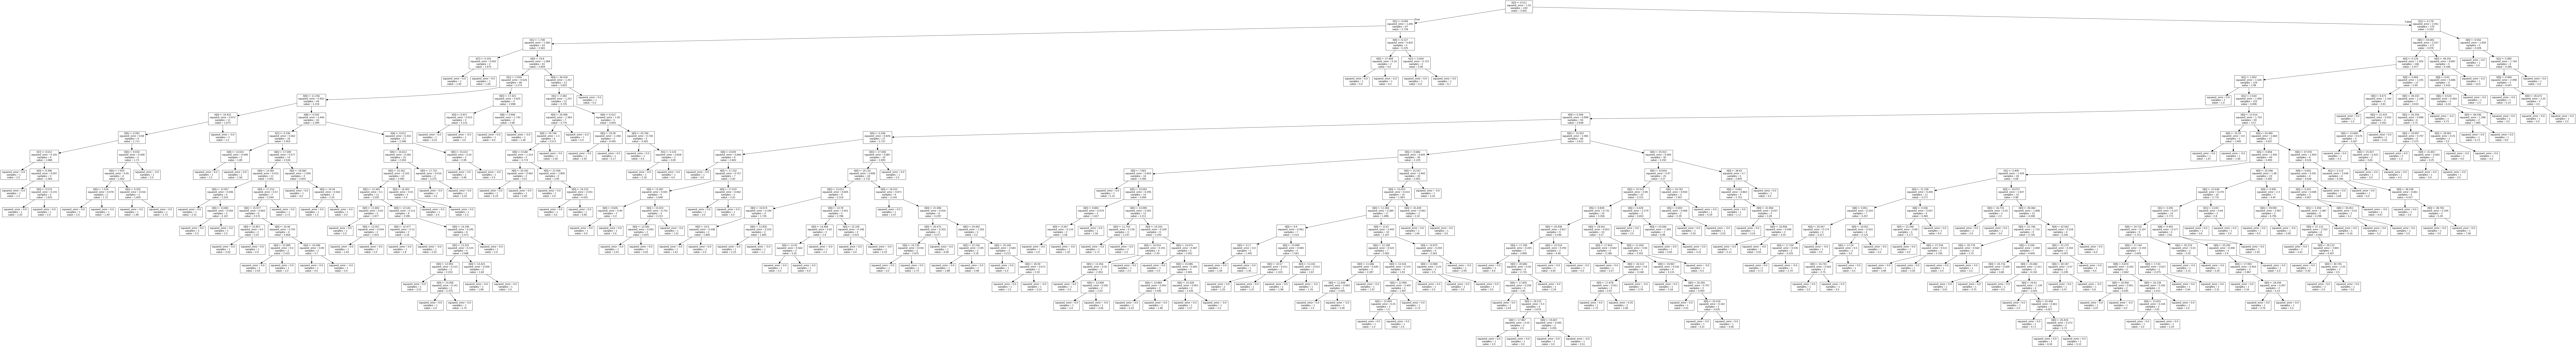

In [86]:
model.fit(X, y)
# import export_graphviz
from sklearn.tree import export_graphviz
# export files as stored as .dot files
dot_file = export_graphviz(model)

# import graphviz to convert .dot file to a .png image
import graphviz
# read the dot_file
graph = graphviz.Source(dot_file)
# convert .dot to .png without generating additional files
graph.render(filename='tree_tips', format='png', cleanup=True)

# import IPython to display the rendered .png image
from IPython.display import Image
# display image using the path
Image(filename="/content/tree_tips.png")

<a name='Pruning'> </a>
# **Pruning the Decision Tree**
Removing the unnecessary elements from the Decision Trees with the aim of:
* Reducing the complexity to avoid overfitting
* Making it easier to interpret.



1. **Pre-Pruning**: the goal is to limit tree growth
  * ***max_depth***: grow up to a certain depth/height
  * ***min_samples_split***: the minimun number of samples required to split an internal node.
  * ***max_leaf_nodes***: limit the total number of leaf nodes allowed in the tree

    Additional info [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

2. **Post-pruning**: build the whole tree and then review the tree and decide which leaves to remove to make it smaller.

<a name='Pre-Pruning'> </a>
**Pre-Pruning** example:

Mean CV training accuracy:
-1.120921071033436

Mean CV testing accuracy:
-1.29972976975674


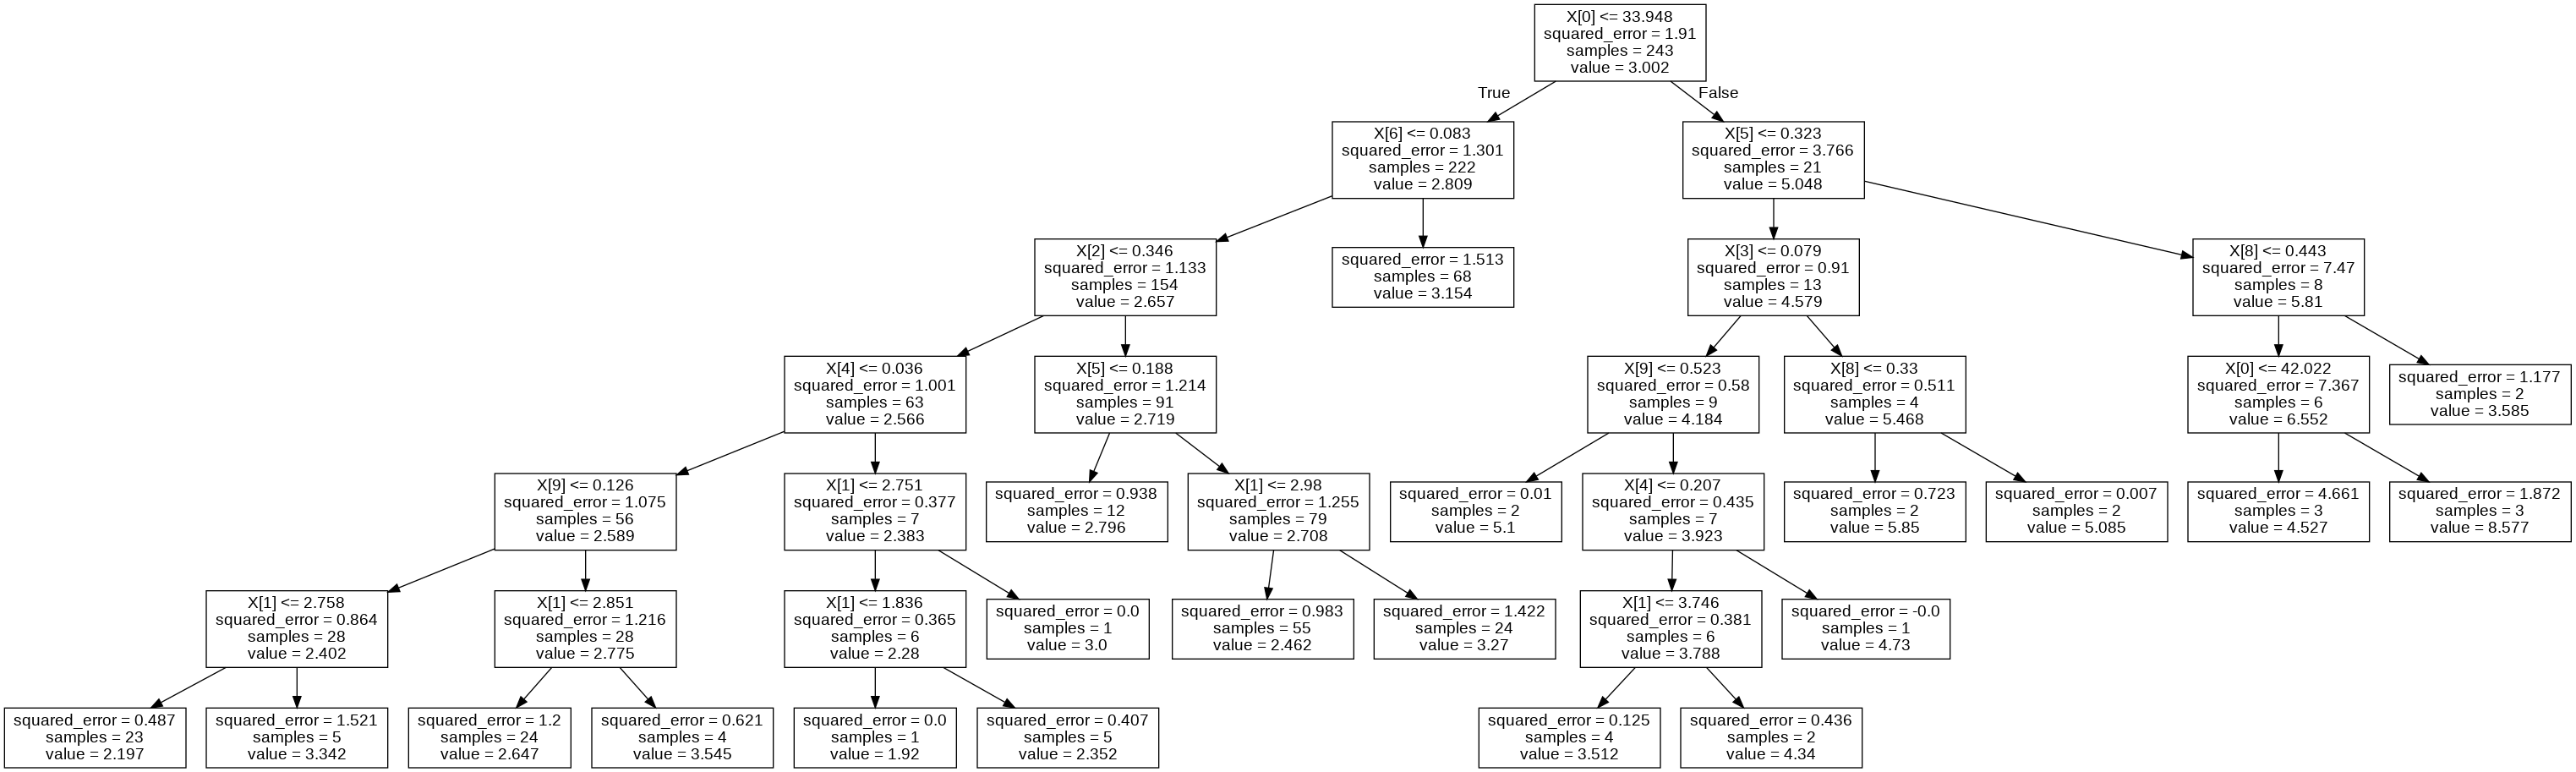

In [90]:
# create the model with modified parameters
model = DecisionTreeRegressor(
    max_features='log2',
    splitter='random',
    max_depth=6,
    min_samples_split=4,
    max_leaf_nodes=20)

# train the model
model.fit(X, y)

cv_scores = cross_validate(model, X, y, scoring='neg_mean_squared_error',
               cv=kf, return_train_score=True)

print("Mean CV training MSE:")
print(np.mean(cv_scores['train_score']))

print("\nMean CV testing MSE:")
print(np.mean(cv_scores['test_score']))

# import export_graphviz
from sklearn.tree import export_graphviz
# export files as stored as .dot files
dot_file = export_graphviz(model)

# import graphviz to convert .dot file to a .png image
import graphviz
# read the dot_file
graph = graphviz.Source(dot_file)
# convert .dot to .png without generating additional files
graph.render(filename='tree_tips', format='png', cleanup=True)

# import IPython to display the rendered .png image
from IPython.display import Image
# display image using the path
Image(filename="/content/tree_tips.png")

Pre-Prunning successfully **reduced overfitting** (difference between training and testing MSE) as well as decreased ***mean squared error*** in comparison to the default model (-1.28... vs. -2.14...).


<a name='Conclusions'> </a>
# **Conclusions**
1. **GraphViz** allows to easily generate a visual representation of the Decision Tree which greatly helps in its ***interpretability***!

2. **Pre-Pruning** technique was successful to considerably ***increase testing accuracy*** and ***minimize overfitting*** with minimal modifications!